In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# ⚙️ Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)



Using device: cpu


In [2]:
class LandmarkEmotionDataset(Dataset):
    def __init__(self, csv_file, label_encoder=None, normalize=True):
        df = pd.read_csv(csv_file)

        # Extract features and labels
        self.X = df.iloc[:, :-1].values.astype(np.float32)
        self.y = df.iloc[:, -1].values

        # Normalize feature-wise (each column = one landmark coordinate)
        if normalize:
            self.mean = self.X.mean(axis=0)
            self.std = self.X.std(axis=0) + 1e-6  # prevent division by 0
            self.X = (self.X - self.mean) / self.std

        # Label encode target
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            self.y = self.label_encoder.fit_transform(self.y)
        else:
            self.label_encoder = label_encoder
            self.y = self.label_encoder.transform(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_tensor = torch.tensor(self.X[idx], dtype=torch.float32)
        y_tensor = torch.tensor(self.y[idx], dtype=torch.long)
        return x_tensor, y_tensor


In [11]:
from torch.utils.data import WeightedRandomSampler, DataLoader

# Load datasets
train_dataset = LandmarkEmotionDataset("cleaned_landmark_train.csv")
test_dataset = LandmarkEmotionDataset("cleaned_landmark_test.csv", label_encoder=train_dataset.label_encoder)
import joblib
joblib.dump(train_dataset.label_encoder, "label_encoder.pkl")
# ✅ Compute class weights for balancing
class_counts = np.bincount(train_dataset.y.astype(int))
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_dataset.y.astype(int)]

# ✅ Use sampler for balanced training
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ Print info
print("Classes:", train_dataset.label_encoder.classes_)
print("Class distribution in train set:", class_counts)


Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Class distribution in train set: [3483  358 3621 6892 4758 4222 2979]


In [4]:
class FERTransformer(nn.Module):
    def __init__(self, input_dim=936, d_model=256, nhead=8, num_layers=4, num_classes=7):
        super(FERTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, 1, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=512, activation='gelu')
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.dropout = nn.Dropout(0.3)
        self.norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # shape: (B, 1, d_model)
        x = x + self.pos_encoding
        x = self.transformer(x)
        x = x.mean(dim=1)  # shape: (B, d_model)
        x = self.norm(x)
        x = self.dropout(x)
        return self.fc(x)



In [5]:
model = FERTransformer(num_classes=len(train_dataset.label_encoder.classes_))

# 🧠 AdamW with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# 🎯 Loss function
criterion = nn.CrossEntropyLoss()

# ⚙️ Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model.to(device)


C:\Users\Sneha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Using device: cpu


FERTransformer(
  (embedding): Linear(in_features=936, out_features=256, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=256, out_features=7, bias=True)
)

In [6]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()

        # 🚫 Clip gradients for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (preds.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


def val_epoch(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            correct += (preds.argmax(1) == y).sum().item()
            total += x.size(0)

    return correct / total



In [7]:
train_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0
best_model_path = "best_fer_transformer.pth"

# 🔁 Optional: Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

for epoch in range(20):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_acc = val_epoch(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # 🔁 Step scheduler
    scheduler.step(val_acc)
    for param_group in optimizer.param_groups:
        print(f"🔧 Current LR: {param_group['lr']}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Epoch {epoch+1}: Best model saved with Val Acc = {val_acc*100:.2f}%")

    print(f"📘 Epoch {epoch+1}/20 | Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")


🔧 Current LR: 0.0001
✅ Epoch 1: Best model saved with Val Acc = 35.47%
📘 Epoch 1/20 | Loss: 1.6955 | Train Acc: 33.35% | Val Acc: 35.47%
🔧 Current LR: 0.0001
📘 Epoch 2/20 | Loss: 1.5136 | Train Acc: 41.64% | Val Acc: 33.24%
🔧 Current LR: 0.0001
✅ Epoch 3: Best model saved with Val Acc = 37.48%
📘 Epoch 3/20 | Loss: 1.4472 | Train Acc: 44.38% | Val Acc: 37.48%
🔧 Current LR: 0.0001
📘 Epoch 4/20 | Loss: 1.4176 | Train Acc: 45.39% | Val Acc: 37.37%
🔧 Current LR: 0.0001
✅ Epoch 5: Best model saved with Val Acc = 39.50%
📘 Epoch 5/20 | Loss: 1.3906 | Train Acc: 46.57% | Val Acc: 39.50%
🔧 Current LR: 0.0001
📘 Epoch 6/20 | Loss: 1.3789 | Train Acc: 46.87% | Val Acc: 37.31%
🔧 Current LR: 0.0001
📘 Epoch 7/20 | Loss: 1.3497 | Train Acc: 48.29% | Val Acc: 39.18%
🔧 Current LR: 0.0001
✅ Epoch 8: Best model saved with Val Acc = 40.14%
📘 Epoch 8/20 | Loss: 1.3130 | Train Acc: 49.74% | Val Acc: 40.14%
🔧 Current LR: 0.0001
📘 Epoch 9/20 | Loss: 1.3094 | Train Acc: 49.62% | Val Acc: 37.70%
🔧 Current LR: 0.0

In [8]:
from sklearn.metrics import classification_report

def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            pred_labels = preds.argmax(1)
            correct += (pred_labels == y).sum().item()
            total += x.size(0)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred_labels.cpu().numpy())

    acc = correct / total
    print(f"\n🧪 Final Test Accuracy: {acc*100:.2f}%\n")
    print(classification_report(y_true, y_pred, target_names=train_dataset.label_encoder.classes_))
    return acc


In [9]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load("best_fer_transformer.pth"))
model.to(device)
evaluate(model, test_loader)



🧪 Final Test Accuracy: 44.18%

              precision    recall  f1-score   support

       angry       0.29      0.32      0.31       831
     disgust       0.15      0.48      0.23        96
        fear       0.24      0.13      0.17       918
       happy       0.75      0.72      0.74      1697
     neutral       0.41      0.39      0.40      1179
         sad       0.30      0.37      0.33      1081
    surprise       0.49      0.51      0.50       765

    accuracy                           0.44      6567
   macro avg       0.38      0.42      0.38      6567
weighted avg       0.45      0.44      0.44      6567



0.44175422567382366

In [10]:
# 🔁 Load the best model (saved during training)
model.load_state_dict(torch.load("best_fer_transformer.pth"))
model.to(device)

# 🧪 Evaluate on test set
test_acc = evaluate(model, test_loader)
print(f"✅ Final Test Accuracy: {test_acc*100:.2f}%")



🧪 Final Test Accuracy: 44.18%

              precision    recall  f1-score   support

       angry       0.29      0.32      0.31       831
     disgust       0.15      0.48      0.23        96
        fear       0.24      0.13      0.17       918
       happy       0.75      0.72      0.74      1697
     neutral       0.41      0.39      0.40      1179
         sad       0.30      0.37      0.33      1081
    surprise       0.49      0.51      0.50       765

    accuracy                           0.44      6567
   macro avg       0.38      0.42      0.38      6567
weighted avg       0.45      0.44      0.44      6567

✅ Final Test Accuracy: 44.18%


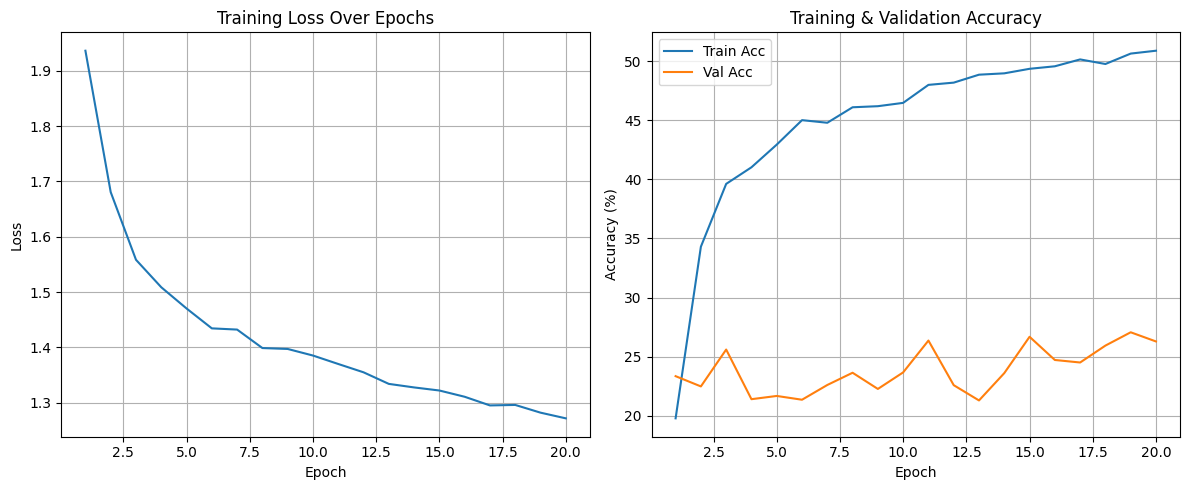

In [41]:
epochs = range(1, 21)

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, [a*100 for a in train_accuracies], label="Train Acc")
plt.plot(epochs, [a*100 for a in val_accuracies], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
